In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, Attributer, get_2dfilts
from utils import tuple_L1Loss, tuple_L2Loss, thresh_attrs, viz_list
from pytorch_wavelets import DTCWTForward, DTCWTInverse, DWTForward, DWTInverse
import pywt

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

## initialize filter

In [47]:
# wavelet transform with initialization
wt = Wavelet_Transform(biort='near_sym_b', qshift='qshift_b', J=4)
# initialization
eps = 0.05
wt.xfm.h0o.data = wt.xfm.h0o.data + eps*torch.randn(wt.xfm.h0o.data.shape).to(device)
wt.xfm.h1o.data = wt.xfm.h1o.data + eps*torch.randn(wt.xfm.h1o.data.shape).to(device)
wt.xfm.h0a.data = wt.xfm.h0a.data + eps*torch.randn(wt.xfm.h0a.data.shape).to(device)
wt.xfm.h1a.data = wt.xfm.h1a.data + eps*torch.randn(wt.xfm.h1a.data.shape).to(device)
wt.xfm.h0b.data = wt.xfm.h0b.data + eps*torch.randn(wt.xfm.h0b.data.shape).to(device)
wt.xfm.h1b.data = wt.xfm.h1b.data + eps*torch.randn(wt.xfm.h1b.data.shape).to(device)
wt.ifm.g0o.data = wt.ifm.g0o.data + eps*torch.randn(wt.ifm.g0o.data.shape).to(device)
wt.ifm.g1o.data = wt.ifm.g1o.data + eps*torch.randn(wt.ifm.g1o.data.shape).to(device)
wt.ifm.g0a.data = wt.ifm.g0a.data + eps*torch.randn(wt.ifm.g0a.data.shape).to(device)
wt.ifm.g1a.data = wt.ifm.g1a.data + eps*torch.randn(wt.ifm.g1a.data.shape).to(device)
wt.ifm.g0b.data = wt.ifm.g0b.data + eps*torch.randn(wt.ifm.g0b.data.shape).to(device)
wt.ifm.g1b.data = wt.ifm.g1b.data + eps*torch.randn(wt.ifm.g1b.data.shape).to(device)

(fl_filt_reals, fl_filt_imags), (sl_filt_reals, sl_filt_imags) = get_2dfilts(wt, wt_type='DTCWT')

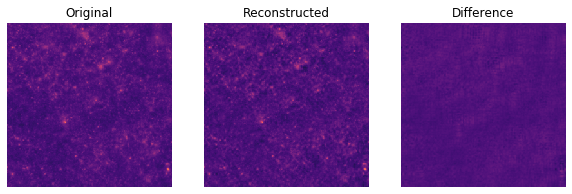

In [48]:
viz_im_r(im[0], wt.inverse(wt(im))[0])

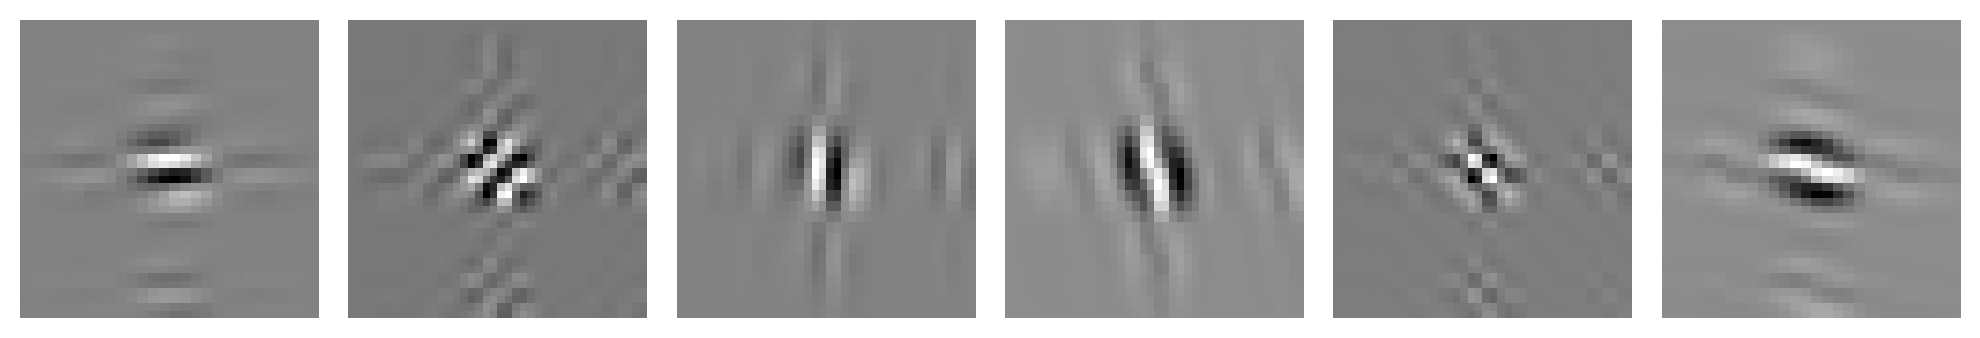

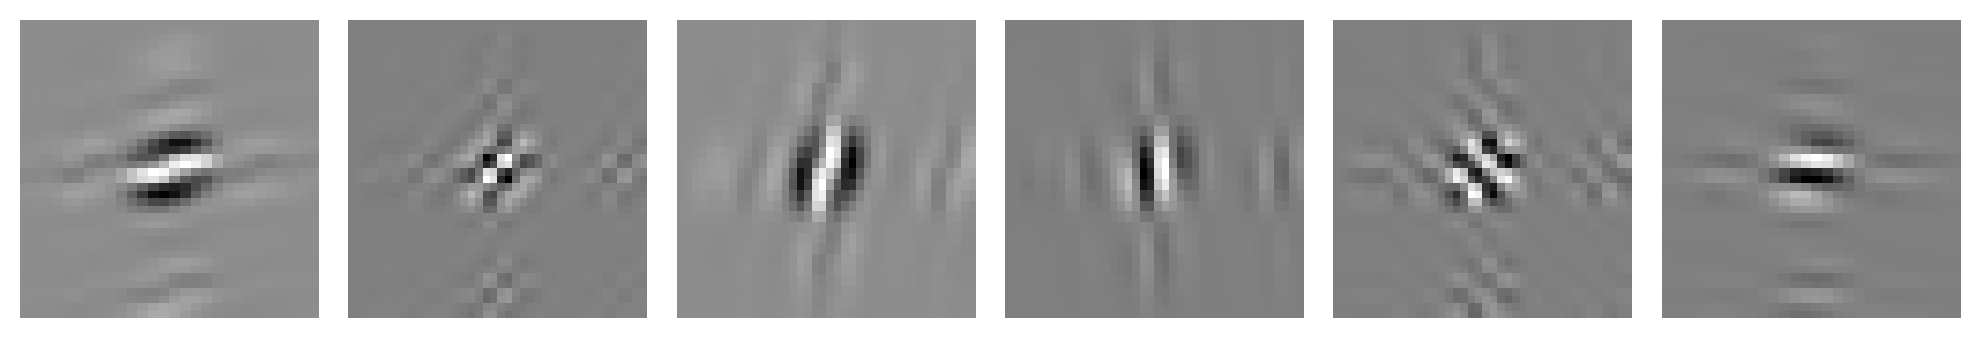

In [49]:
viz_list(fl_filt_reals)
viz_list(fl_filt_imags)

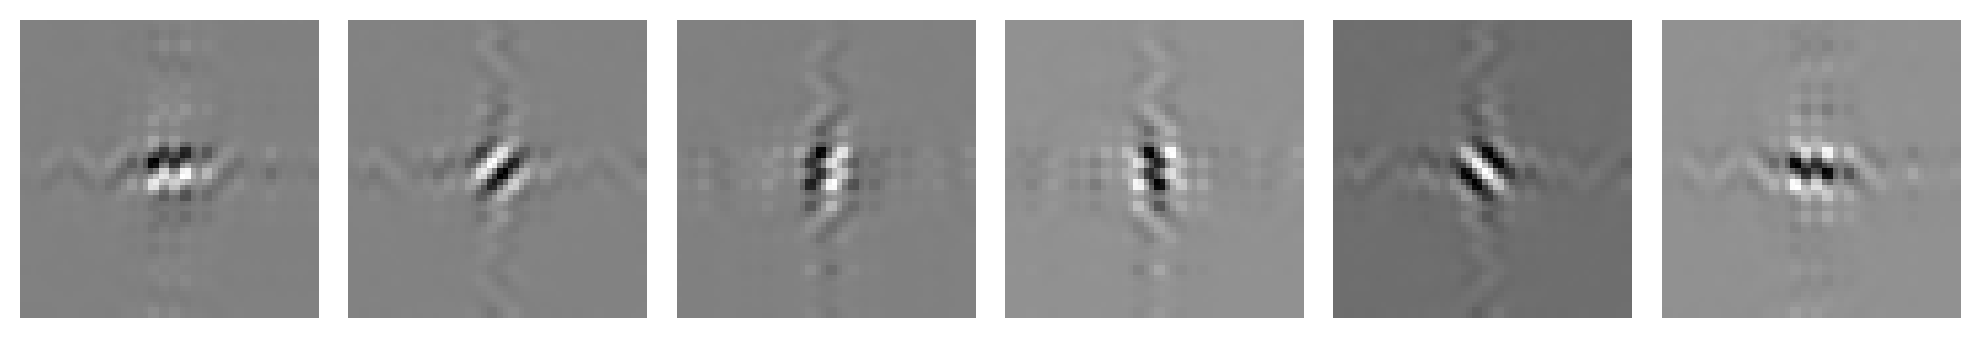

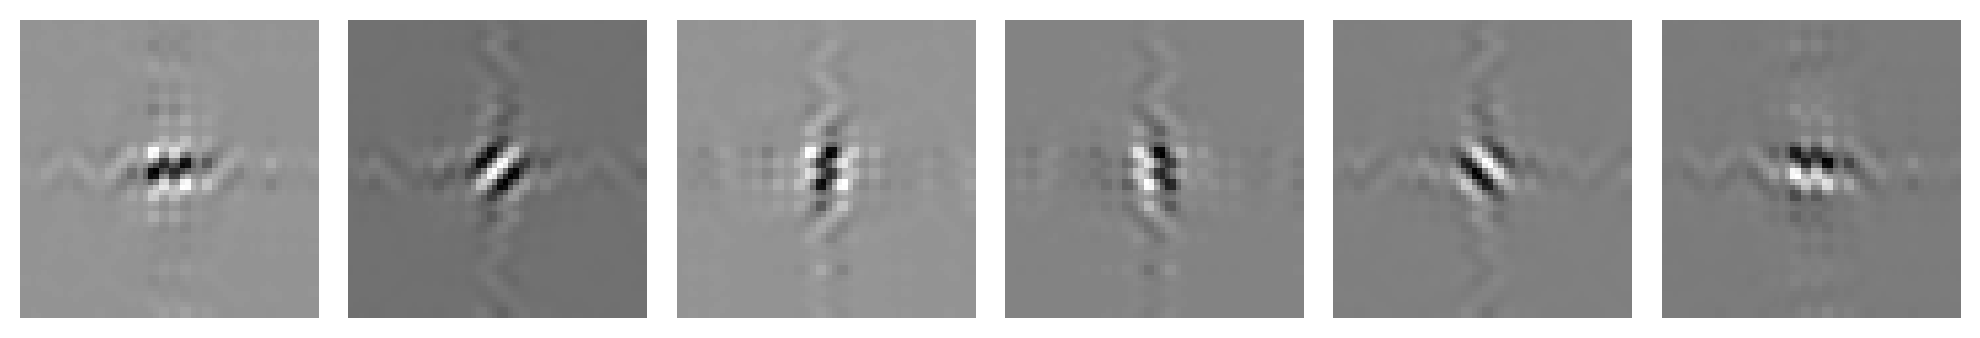

In [50]:
viz_list(sl_filt_reals)
viz_list(sl_filt_imags)

## optimize filter

In [62]:
# optimization params
losses = []
num_epochs = 5

params = list(wt.xfm.parameters()) + list(wt.ifm.parameters())
optimizer = torch.optim.SGD(params, lr=0.001)

In [63]:
# Training Loop
# Lists to keep track of progress
init_losses = [torch.norm(wt.inverse(wt(im)) - im)**2]
print("Initial Loss: Recon={:.3f}".format(init_losses[0].data.item()))
print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    epoch_loss = 0
    # For each batch in the dataloader
    for batch_idx, (data, _) in enumerate(train_loader, 0):  
        data = data.to(device)
        # zero grad
        optimizer.zero_grad()    
        # loss
        im_t = wt(data)
        recon_data = wt.inverse(im_t)
        loss = _reconstruction_loss(data, recon_data, distribution="gaussian", storer=None)
        # backward
        loss.backward()
        # Update step
        optimizer.step()
        
        epoch_loss += loss.data.item()
        
        # Output training stats
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), loss.data.item()), end='')        
        
    # Save Losses for plotting later
    losses.append(epoch_loss/(batch_idx + 1))        

final_losses = [torch.norm(wt.inverse(wt(im)) - im)**2]
print("\nFinal Loss: Recon={:.3f}".format(final_losses[0].data.item()))

Initial Loss: Recon=0.389
Starting Training Loop...
Train Epoch: 4 [15600/25000 (100%)]	Loss: 0.001741
Final Loss: Recon=0.112


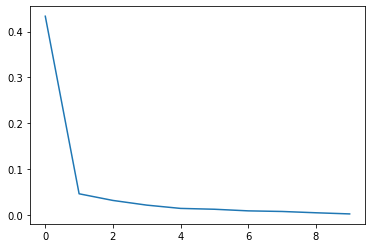

In [64]:
plt.plot(losses)

In [65]:
(fl_filt_reals, fl_filt_imags), (sl_filt_reals, sl_filt_imags) = get_2dfilts(wt, wt_type='DTCWT')

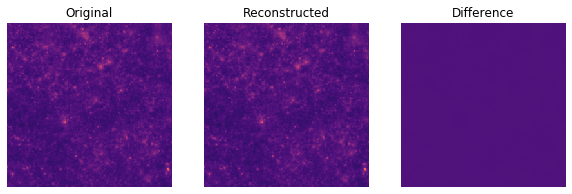

In [66]:
viz_im_r(im[0], wt.inverse(wt(im))[0])

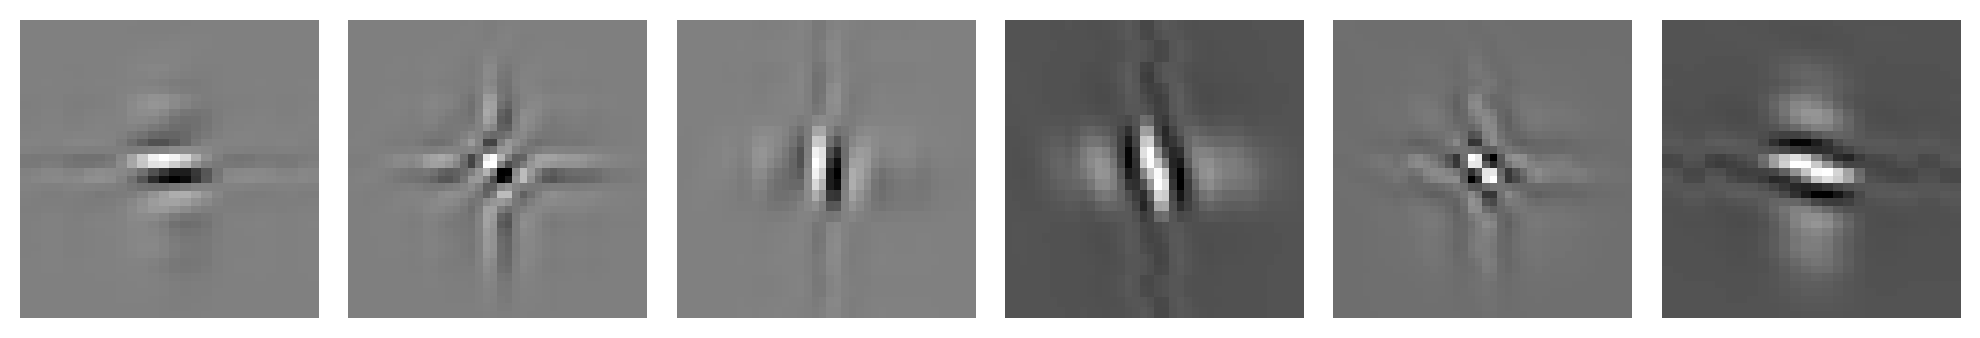

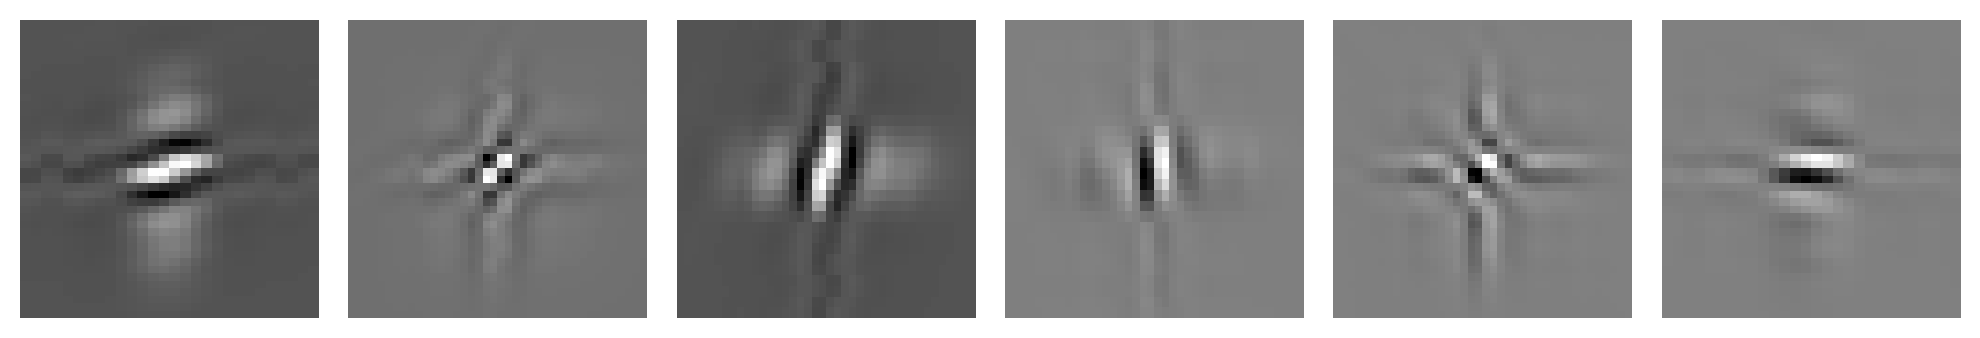

In [67]:
viz_list(fl_filt_reals)
viz_list(fl_filt_imags)

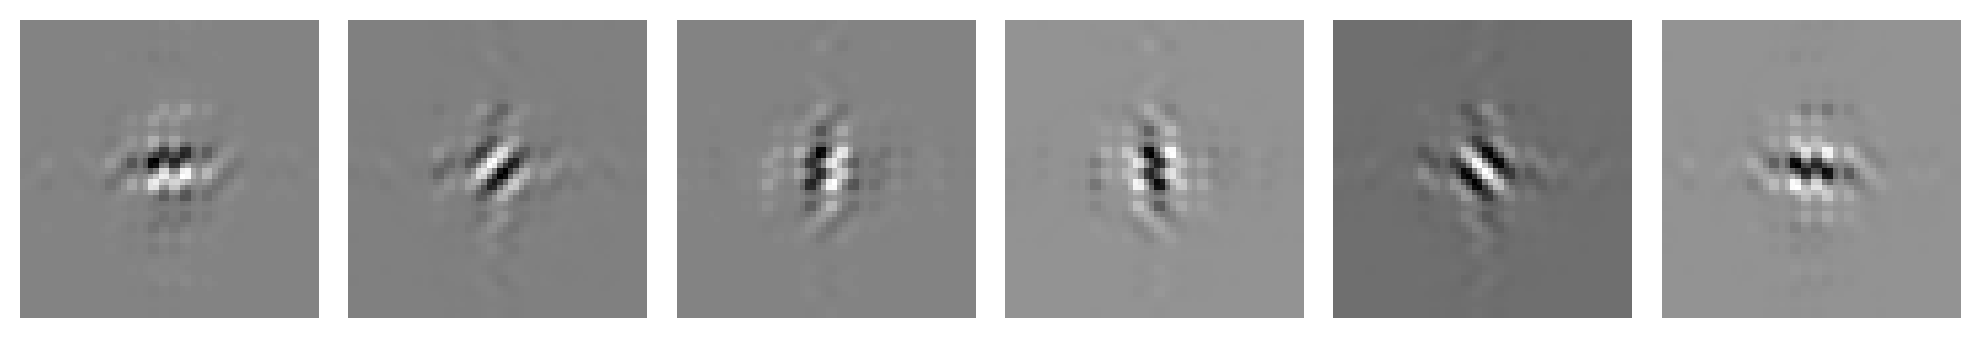

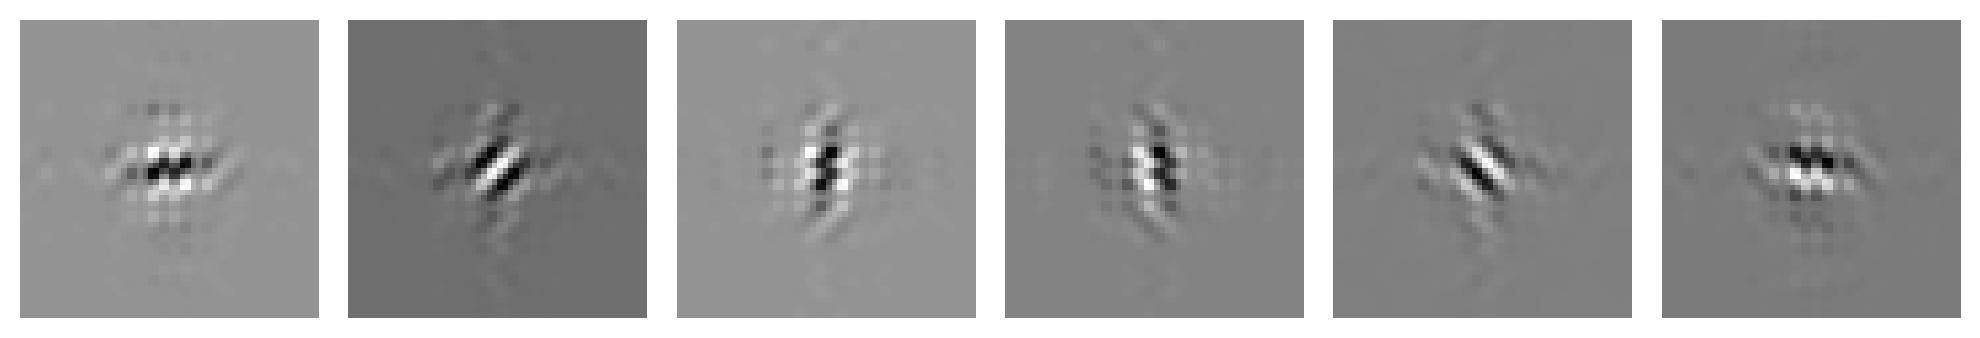

In [68]:
viz_list(sl_filt_reals)
viz_list(sl_filt_imags)